In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!mkdir "/content/COVID_Xray/"

In [3]:
!unzip "/content/drive/My Drive/COVID/Dataset/train.zip" -d /content/COVID_Xray/

Archive:  /content/drive/My Drive/COVID/Dataset/train.zip
   creating: /content/COVID_Xray/train/Covid/
  inflating: /content/COVID_Xray/train/Covid/Covid_1.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_10.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_100.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_101.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_102.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_103.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_104.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_105.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_106.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_107.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_108.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_109.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_11.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_110.png  
  inflating: /content/COVID_Xray/train/Covid/C

In [4]:
!unzip "/content/drive/My Drive/COVID/Dataset/test.zip" -d /content/COVID_Xray/

Archive:  /content/drive/My Drive/COVID/Dataset/test.zip
   creating: /content/COVID_Xray/test/Covid/
  inflating: /content/COVID_Xray/test/Covid/Covid_709.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_710.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_711.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_712.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_713.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_714.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_715.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_716.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_717.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_718.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_719.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_720.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_721.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_722.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_723.png 

In [5]:
import os
from os.path import basename, join, exists

In [6]:
os.chdir(r"/content/COVID_Xray/")

In [7]:
ls

test/  train/


In [8]:
train_dir="train/"
test_dir="test/"

total=0
print('---Training set details----')
for sub_folder in os.listdir(train_dir):
  no_of_images=len(os.listdir(train_dir + sub_folder))
  total+=no_of_images
  print(str(no_of_images) + " " + sub_folder + " images")

print("Total no. of Chest Xray training images=",total)

---Training set details----
1599 Normal images
712 Covid images
1544 Pneumonia images
Total no. of Chest Xray training images= 3855


In [9]:
total=0
print('---Test set details----')
for sub_folder in os.listdir(test_dir):
  no_of_images=len(os.listdir(test_dir + sub_folder))
  total+=no_of_images
  print(str(no_of_images) + " " + sub_folder + " images")

print("Total no. of Chest Xray test images=",total)

---Test set details----
40 Normal images
40 Covid images
40 Pneumonia images
Total no. of Chest Xray test images= 120


In [10]:
!mkdir "/content/COVID_Xray/extracted_features/"

In [11]:
extracted_features_dir="/content/COVID_Xray/extracted_features/"

In [12]:
import numpy as np
np.random.seed(777)
import time
import keras as keras
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from keras.layers import merge,Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# DCNN Models used
#---------------------------------------------
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as pi_xcep 
#----------------------------------------------
from numpy import array
from numpy import argmax
from sklearn.metrics import accuracy_score
from  numpy import mean 
from numpy import std
import matplotlib.pyplot as plt
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Concatenate
from keras.layers import BatchNormalization,Dropout
from keras.layers import Lambda
from keras.regularizers import l2
import math
from keras import backend as K
from keras.metrics import categorical_accuracy
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.models import load_model

In [13]:
img_height =512
img_width = 512
batch_size =32
input_shape = (img_width, img_height, 3)

In [14]:
print("-----------------Image Augmentation for VGG19--------------")

random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split= 0.2,
    zoom_range=0.1,
    shear_range=0.2)

train_generator_xcep = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'training',
    class_mode='categorical')

val_generator_xcep = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'validation',
    class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator_xcep=test_datagen.flow_from_directory(test_dir,
                                                      target_size=(img_height, img_width),
                                                          batch_size=batch_size, 
                                                          seed=random_seed,
                                                          shuffle=False,
                                                          class_mode='categorical') 



-----------------Image Augmentation for VGG19--------------
Found 3086 images belonging to 3 classes.
Found 769 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [15]:

nb_train_samples = len(train_generator_xcep.filenames)
nb_validation_samples = len(val_generator_xcep.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator_xcep.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
print(nb_train_samples)
print(nb_validation_samples)
print(nb_test_samples)
print(predict_size_train)
print(predict_size_validation)
print(predict_size_test)

3086
769
120
97
25
4


In [ ]:
model_name="Xception"
model = Xception(include_top=False, weights="imagenet",pooling='avg',input_shape=input_shape)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
image_input =model.input
x1 = GlobalAveragePooling2D()(model.get_layer("block4_sepconv1_act").output) #layer_26
x2 = GlobalAveragePooling2D()(model.get_layer("block5_sepconv1_act").output) #layer_36
x3 = GlobalAveragePooling2D()(model.get_layer("block14_sepconv1").output)  #layer_126
out= Concatenate()([x1,x2,x3])
custom_xcep_model = Model(image_input , out)
custom_xcep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
for i, layer in enumerate(custom_xcep_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
for layer in custom_xcep_model.layers[:115]:
    layer.trainable = False
custom_xcep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
#Saving features of the training images
bottleneck_features_train = custom_xcep_model.predict_generator(train_generator_xcep, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [ ]:
# Saving features of the validation images
bottleneck_features_validation = custom_xcep_model.predict_generator(val_generator_xcep, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [ ]:
# Saving features of the test images
bottleneck_features_test = custom_xcep_model.predict_generator(test_generator_xcep, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [ ]:
train_data=np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data=np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data=np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

In [ ]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(3086, 2520)
(769, 2520)
(120, 2520)


In [ ]:
train_labels=train_generator_xcep.classes
train_labels=train_labels = keras.utils.to_categorical(train_labels, num_classes=3)
validation_labels=val_generator_xcep.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=3)
test_labels=test_generator_xcep.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=3)

In [ ]:
print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

(3086, 3)
(769, 3)
(120, 3)


In [ ]:

model = Sequential()
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax',name= 'output'))

adam_opt=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8,amsgrad=True)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)


Epoch 1/1000
97/97 - 1s - loss: 0.7836 - accuracy: 0.7353 - val_loss: 0.4103 - val_accuracy: 0.8635
Epoch 2/1000
97/97 - 0s - loss: 0.4272 - accuracy: 0.8351 - val_loss: 0.3641 - val_accuracy: 0.8661
Epoch 3/1000
97/97 - 0s - loss: 0.3905 - accuracy: 0.8522 - val_loss: 0.3829 - val_accuracy: 0.8362
Epoch 4/1000
97/97 - 0s - loss: 0.3741 - accuracy: 0.8529 - val_loss: 0.3653 - val_accuracy: 0.8713
Epoch 5/1000
97/97 - 0s - loss: 0.3521 - accuracy: 0.8564 - val_loss: 0.3555 - val_accuracy: 0.8713
Epoch 6/1000
97/97 - 0s - loss: 0.3554 - accuracy: 0.8620 - val_loss: 0.3608 - val_accuracy: 0.8622
Epoch 7/1000
97/97 - 0s - loss: 0.3410 - accuracy: 0.8639 - val_loss: 0.3287 - val_accuracy: 0.8778
Epoch 8/1000
97/97 - 0s - loss: 0.3280 - accuracy: 0.8681 - val_loss: 0.3581 - val_accuracy: 0.8492
Epoch 9/1000
97/97 - 0s - loss: 0.3260 - accuracy: 0.8684 - val_loss: 0.3214 - val_accuracy: 0.8752
Epoch 10/1000
97/97 - 0s - loss: 0.3170 - accuracy: 0.8707 - val_loss: 0.3160 - val_accuracy: 0.8778

In [ ]:
preds = model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Validation Accuracy=0.9089726918075423


In [ ]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
#cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy=0.8666666666666667


In [ ]:
model.save('/content/drive/My Drive/COVID/saved models/Xception/covid_xception_input_dim_{}_fine_tuning_{}.h5'.format(512,17))
model.save_weights('/content/drive/My Drive/COVID/saved models/Xception/covid_xception_input_dim_{}_fine_tuning_{}_weights.h5'.format(512,17))

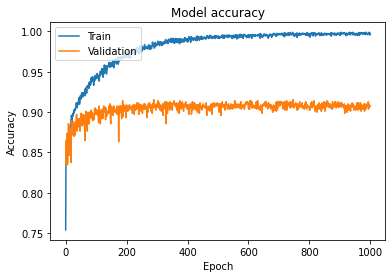

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

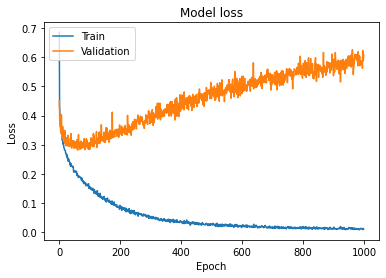

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [26]:
loaded_model=load_model('/content/drive/MyDrive/COVID/saved models/Xception/covid_xception_input_dim_512_fine_tuning_17.h5',compile=False)
loaded_model.load_weights('/content/drive/MyDrive/COVID/saved models/Xception/covid_xception_input_dim_512_fine_tuning_17_weights.h5')

In [17]:
training_data=np.load('/content/drive/MyDrive/COVID/Feature Extraction/Xception/Xception_train_features.npy')
validation_data=np.load('/content/drive/MyDrive/COVID/Feature Extraction/Xception/Xception_val_features.npy')
test_data=np.load('/content/drive/MyDrive/COVID/Feature Extraction/Xception/Xception_test_features.npy')

In [18]:
train_labels=train_generator_xcep.classes
train_labels = keras.utils.to_categorical(train_labels, num_classes=3)
validation_labels=val_generator_xcep.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=3)
test_labels=test_generator_xcep.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=3)

In [21]:
preds = loaded_model.predict(training_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in train_labels]
print('training Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

training Accuracy=1.0


In [23]:
import pandas as pd
train_df=pd.read_csv('/content/drive/My Drive/COVID/Train_Prediction_matrix.csv')
train_df

,Unnamed: 0,True Label,vgg16
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
3081,3081,2,2
3082,3082,2,2
3083,3083,2,2
3084,3084,2,2


In [24]:
preds = loaded_model.predict(training_data)
predictions = [i.argmax() for i in preds]
train_df['xception']=predictions
train_df

,Unnamed: 0,True Label,vgg16,xception
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0
...,...,...,...,...
3081,3081,2,2,2
3082,3082,2,2,2
3083,3083,2,2,2
3084,3084,2,2,2


In [25]:
train_df.to_csv('/content/drive/My Drive/COVID/Train_Prediction_matrix.csv')

In [ ]:
preds = loaded_model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Validation Accuracy=0.9076723016905072


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns
import pandas as pd

In [ ]:
preds = loaded_model.predict(test_data)

y_pred = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)

print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=y_pred)))

Test Accuracy=0.925


In [ ]:
for i in y_pred:
  print(i,end=",")

0,0,0,2,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,

CONFUSION MATRIX


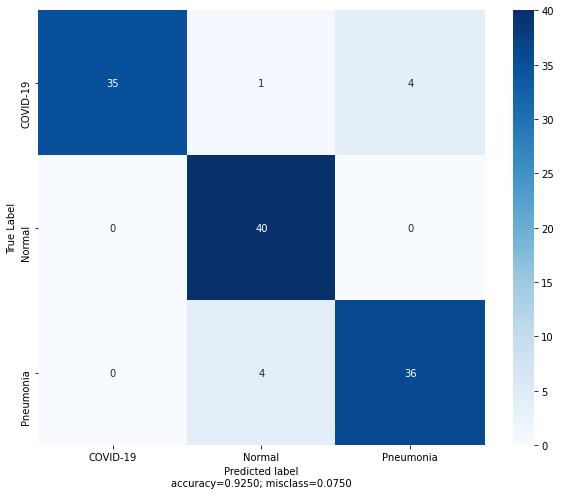

The details for confusion matrix is =
              precision    recall  f1-score   support

    COVID-19       1.00      0.88      0.93        40
      Normal       0.89      1.00      0.94        40
   Pneumonia       0.90      0.90      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.92       120
weighted avg       0.93      0.93      0.92       120



In [ ]:
print('CONFUSION MATRIX')
conf_matrix = pd.DataFrame(data = cm,  
                           columns = ['COVID-19','Normal','Pneumonia'],  
                           index =['COVID-19','Normal','Pneumonia']) 

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
plt.figure(figsize = (10,8)) 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues") 
plt.ylabel('True Label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show() 

target_names=['COVID-19','Normal','Pneumonia']
print('The details for confusion matrix is =') 
print (classification_report(y_true, y_pred,target_names=target_names))

In [ ]:
import pandas as pd

In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')

In [ ]:
test_df

,Unnamed: 0,True Label,vgg16_class0,vgg16_class1,vgg16_class2
0,0,0,9.997659e-01,1.618086e-11,2.340811e-04
1,1,0,1.000000e+00,3.336014e-15,3.459131e-09
2,2,0,1.000000e+00,4.013379e-14,3.260767e-12
3,3,0,9.986774e-01,1.859167e-06,1.320634e-03
4,4,0,4.096806e-01,3.651214e-02,5.538073e-01
...,...,...,...,...,...
115,115,2,5.289370e-13,1.708974e-02,9.829102e-01
116,116,2,4.523590e-13,1.193429e-02,9.880657e-01
117,117,2,1.754031e-13,9.999989e-01,1.128248e-06
118,118,2,3.275368e-11,5.605959e-06,9.999944e-01


In [ ]:
conf_score= loaded_model.predict(test_data)
y_true = [i.argmax() for i in test_labels]

In [ ]:
for i in range(0,3):
  test_df['xception_class'+str(i)]=conf_score[:,i]


In [ ]:
test_df

,Unnamed: 0,True Label,vgg16_class0,vgg16_class1,vgg16_class2,xception_class0,xception_class1,xception_class2
0,0,0,9.997659e-01,1.618086e-11,2.340811e-04,9.994861e-01,2.525694e-12,5.139261e-04
1,1,0,1.000000e+00,3.336014e-15,3.459131e-09,9.997345e-01,6.661170e-15,2.654911e-04
2,2,0,1.000000e+00,4.013379e-14,3.260767e-12,1.000000e+00,1.820435e-15,3.275298e-08
3,3,0,9.986774e-01,1.859167e-06,1.320634e-03,3.295750e-01,1.761833e-04,6.702489e-01
4,4,0,4.096806e-01,3.651214e-02,5.538073e-01,2.901666e-01,6.982374e-01,1.159600e-02
...,...,...,...,...,...,...,...,...
115,115,2,5.289370e-13,1.708974e-02,9.829102e-01,2.985189e-13,2.784816e-03,9.972152e-01
116,116,2,4.523590e-13,1.193429e-02,9.880657e-01,1.305408e-08,5.878432e-02,9.412156e-01
117,117,2,1.754031e-13,9.999989e-01,1.128248e-06,1.004209e-12,9.974482e-01,2.551764e-03
118,118,2,3.275368e-11,5.605959e-06,9.999944e-01,4.922030e-12,5.157485e-12,1.000000e+00


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')

Prediction Matrix

In [ ]:
val_df=pd.read_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')
val_df

,Unnamed: 0,True Label,vgg16
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
764,764,2,2
765,765,2,2
766,766,2,2
767,767,2,2


In [ ]:
preds = loaded_model.predict(validation_data)
predictions = [i.argmax() for i in preds]
val_df['xception']=predictions
val_df

,Unnamed: 0,True Label,vgg16,xception
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0
...,...,...,...,...
764,764,2,2,2
765,765,2,2,2
766,766,2,2,2
767,767,2,2,2


In [ ]:
val_df.to_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')

In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')
test_df

,Unnamed: 0,True Label,vgg16
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,2
...,...,...,...
115,115,2,2
116,116,2,2
117,117,2,1
118,118,2,2


In [ ]:
preds = loaded_model.predict(test_data)
predictions = [i.argmax() for i in preds]
test_df['xception']=predictions
test_df

,Unnamed: 0,True Label,vgg16,xception
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,2
4,4,0,2,1
...,...,...,...,...
115,115,2,2,2
116,116,2,2,2
117,117,2,1,1
118,118,2,2,2


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')